<img src="https://github.com/d9w/evolution/raw/master/imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Algorithms

## Evolving Neural Networks with ES

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

In order to visualize the environment in this notebook, you will need to install the following:

In [1]:
#!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [2]:
#!pip install cma pyvirtualdisplay gym[box2d] pygame

In [3]:
# pip install torch

In [4]:
# pip install numpy

In [5]:
# pip install gym

In [6]:
# pip install pyvirtualdisplay

In [7]:
# pip install matplotlib

In [8]:
# pip install swig

In [9]:
# pip install box2d pygame

In [10]:
# pip install box2d box2d-kengz

In [11]:
# pip install cma

# <a name="neuroevolution">3.</a> ES for Neuroevolution

Evolutionary strategies are intended for continuous optimization and can easily be applied to the optimization of neural network parameters, or *neuroevolution*. 

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import numpy as np
import gym

In [13]:
class NeuralNetwork(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(input_shape, 32)
        self.l2 = nn.Linear(32, 32)
        self.l3 = nn.Linear(32, 32)
        self.l4 = nn.Linear(32, 32)
        self.lout = nn.Linear(32, n_actions)
        
    def forward(self, x):
        x = F.relu(self.l1(x.float()))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.lout(x)
    
    def get_params(self):
        p = np.empty((0,))
        for n in self.parameters():
            p = np.append(p, n.flatten().cpu().detach().numpy())
        return p
    
    def set_params(self, x):
        start = 0
        for p in self.parameters():
            e = start + np.prod(p.shape)
            p.data = torch.FloatTensor(x[start:e]).reshape(p.shape)
            start = e

We'll add some visualization functionality to have the environment render directly in the notebook.

In [14]:
from pyvirtualdisplay import Display
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
pydisplay = Display(visible=0, size=(1400, 900))
pydisplay.start()
plt.ion();

Following the framework of evolutionary policy search, we will optimize a neural network representing a policy and maximize the total reward over a single episode using this policy.

In [15]:
def evaluate(ann, env, visul=True):
    obs, info = env.reset(seed=0)
    if visul:
        img = plt.imshow(env.render())
    total_reward = 0
    while True:
        # Output of the neural net
        net_output = ann(torch.tensor(obs))
        # the action is the value clipped returned by the nn
        action = net_output.data.cpu().numpy().argmax()
        obs, reward, done, truncated, info = env.step(action)
        total_reward += reward
        if visul:
            img.set_data(env.render())
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
        if done:
            break
    return total_reward

We've configured this for discrete action spaces. We can see a random neural network on different environments like `CartPole-v0`, `MountainCar-v0`, and `LunarLander-v2`.

In [16]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")
# env = gym.make('CartPole-v0', render_mode="rgb_array")
# env = gym.make('MountainCar-v0', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)

-119.05959591305864

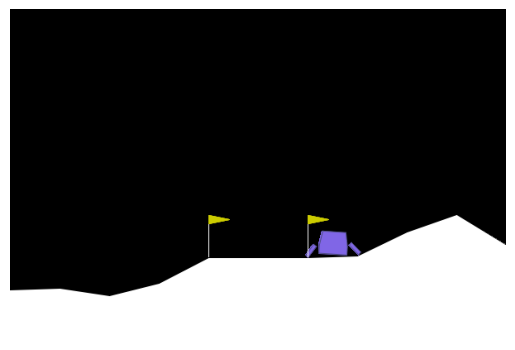

In [17]:
evaluate(ann, env, visul=True)

In order to evolve the parameters of this neural network, we will modify the parameters of the network using `set_params` with the genes of the new individual. In the evolutionary literature, this is referred to as a *direct encoding* as the neural network parameters are directly encoded in the genome.

In [18]:
def fitness(x, ann, env, visul=False):
    ann.set_params(x)
    return -evaluate(ann, env, visul=visul)

In [19]:
p = ann.get_params()
np.shape(p)

(3588,)

We can first observe a random individual $x$.

-119.05959591305864

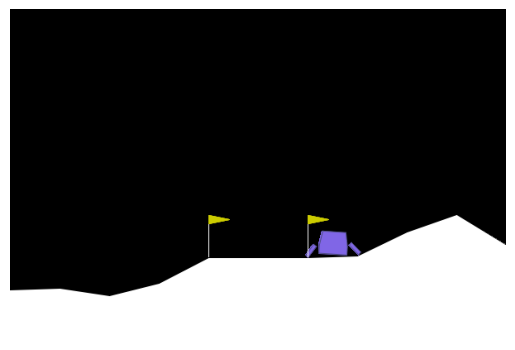

In [20]:
x = np.random.rand(len(p))
-fitness(x, ann, env, visul=True)

Let's try optimizing the policy using the simple $(\mu, \lambda)$ ES we proposed.

In [21]:
def mu_lambda(x, fitness, gens=200, lam=10, alpha=0.2, verbose=False):
    x_best = x
    f_best = fitness(x)
    fits = np.zeros(gens)
    for g in range(gens):
        N = np.random.normal(size=(lam, len(x)))
        F = np.zeros(lam)
        for i in range(lam):
            ind = x + N[i, :]
            F[i] = fitness(ind)
            if F[i] < f_best:
                f_best = F[i]
                x_best = ind
                if verbose:
                    print(g, " ", f_best)
        fits[g] = f_best
        mu_f = np.mean(F)
        std_f = np.std(F)
        A = F
        if std_f != 0:
            A = (F - mu_f) / std_f
        x = x - alpha * np.dot(A, N) / lam
    return fits, x_best

In [22]:
# np.random.seed(654)
# env = gym.make('CartPole-v0', render_mode='rgb_array')
# env = gym.make('MountainCar-v0', render_mode='rgb_array')
env = gym.make('LunarLander-v2', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
x = np.random.randn(len(ann.get_params()))
f = lambda x : fitness(x, ann, env)
fits, x = mu_lambda(x, f, gens=200, lam=10, alpha=0.2, verbose=True)

0   119.05959591305864
4   98.18632193797632
4   -9.949085132493153
24   -12.69714195433805
30   -41.47226109676308
43   -48.03872412945151


In [23]:
fits

array([119.05959591, 119.05959591, 119.05959591, 119.05959591,
        -9.94908513,  -9.94908513,  -9.94908513,  -9.94908513,
        -9.94908513,  -9.94908513,  -9.94908513,  -9.94908513,
        -9.94908513,  -9.94908513,  -9.94908513,  -9.94908513,
        -9.94908513,  -9.94908513,  -9.94908513,  -9.94908513,
        -9.94908513,  -9.94908513,  -9.94908513,  -9.94908513,
       -12.69714195, -12.69714195, -12.69714195, -12.69714195,
       -12.69714195, -12.69714195, -41.4722611 , -41.4722611 ,
       -41.4722611 , -41.4722611 , -41.4722611 , -41.4722611 ,
       -41.4722611 , -41.4722611 , -41.4722611 , -41.4722611 ,
       -41.4722611 , -41.4722611 , -41.4722611 , -48.03872413,
       -48.03872413, -48.03872413, -48.03872413, -48.03872413,
       -48.03872413, -48.03872413, -48.03872413, -48.03872413,
       -48.03872413, -48.03872413, -48.03872413, -48.03872413,
       -48.03872413, -48.03872413, -48.03872413, -48.03872413,
       -48.03872413, -48.03872413, -48.03872413, -48.03

If all the individuals in a generation perform the same, this proves that there is diversity loss. Diversity loss leads to progress stagnation

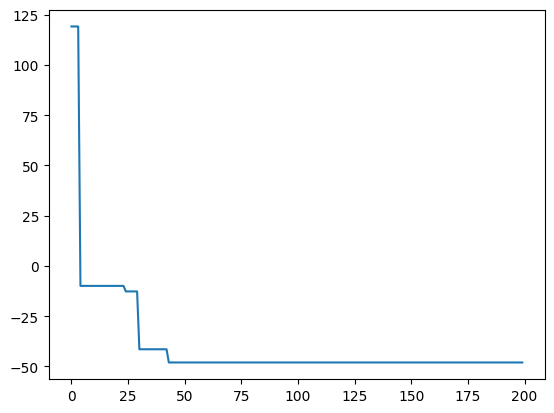

In [24]:
plt.plot(fits);

48.03872412945151

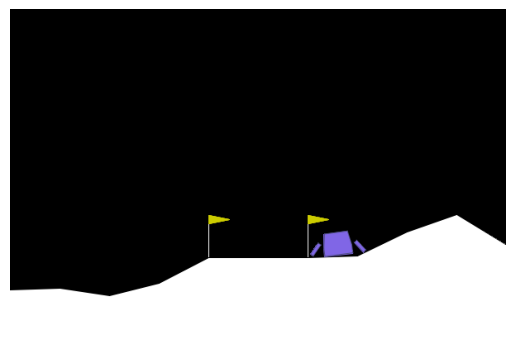

In [25]:
-fitness(x, ann, env, visul=True)

# CMA-ES for Neuroevolution

We will now use CMA-ES for the Lunar Lander problem

In [26]:
import cma
# np.random.seed(123)
env = gym.make('LunarLander-v2', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
# es = cma.CMAEvolutionStrategy(len(ann.get_params()) * [0], 0.2, {'seed': 123})
es = cma.CMAEvolutionStrategy(len(ann.get_params()) * [0], 0.2)

(14_w,28)-aCMA-ES (mu_w=8.1,w_1=21%) in dimension 3588 (seed=827154, Wed Apr 10 11:30:55 2024)


In [27]:
for i in range(20):
    solutions = np.array(es.ask())
    fits = [fitness(x, ann, env) for x in solutions]
    es.tell(solutions, fits)
    es.disp()

/home/ugo/ISAE-SUPAERO/EvoAlgo/evolution/.conda/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     28 1.190595959130586e+02 1.0e+00 1.99e-01  2e-01  2e-01 0:01.1
    2     56 1.022755194265356e+02 1.0e+00 1.99e-01  2e-01  2e-01 0:02.5
    3     84 8.722029713114912e+01 1.0e+00 1.99e-01  2e-01  2e-01 0:03.7
    6    168 2.177441801306595e+01 1.0e+00 1.97e-01  2e-01  2e-01 0:06.8
   12    336 -2.096096129187332e+01 1.0e+00 1.95e-01  2e-01  2e-01 0:11.4
   18    504 8.473402154049347e+01 1.0e+00 1.92e-01  2e-01  2e-01 0:16.8


Fevals is the number of evaluations for the generation, this gives the number of individuals in each generation?

68.13462583653637

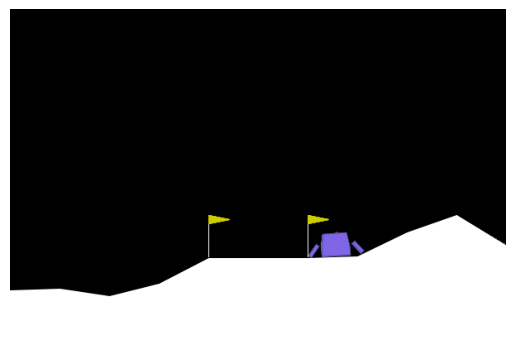

In [28]:
x = es.result[0]
-fitness(x, ann, env, visul=True)

The results on LunarLander clearly show the benefits of CMA-ES; we have found a reasonable policy in a small number of generations. Applying CMA-ES to larger neural networks remains an open challenge, however, due to the vast number of parameters in ANNs. Specifically, CMA-ES calculates the covariance of all parameters, which is $O(n^2)$.

In [29]:
np.shape(es.sm.C)

(3588, 3588)

<div class="alert alert-success">
    <h3>Exercise 1</h3>
    
The network used has 2 layers of 32 neurons each. Try changing this and noticing the impact on the number of total parameters for CMA-ES. How large of a network can CMA-ES optimize?
</div>

For this small initial network, CMA-ES already has a matrix of 1476\*1476. By changing all the layer dimension to 64, the matrix becomes 4996\*4996. This makes the total parameters a lot higher. 2million vs 25million
By adding 4 layers of 32 neurons each, the number goes to 3588\*3588.(about 13million parameters)

<div class="alert alert-success">
    <h3>Exercise 2</h3>
    
Compare the $(1+\lambda)$ ES, $(\mu,\lambda)$ ES, and CMA-ES algorithms on Lunar Lander. Is one significantly better than the others, consistently across different initializations?
</div>

In [30]:
env = gym.make('LunarLander-v2', render_mode='rgb_array')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
es = cma.CMAEvolutionStrategy(len(ann.get_params()) * [0], 0.2)

x = np.random.randn(len(ann.get_params()))
f = lambda x : fitness(x, ann, env)
fits, x = mu_lambda(x, f, gens=200, lam=10, alpha=0.2, verbose=True)


(14_w,28)-aCMA-ES (mu_w=8.1,w_1=21%) in dimension 3588 (seed=870575, Wed Apr 10 11:31:19 2024)
0   119.05959591305864
1   86.32136923500084
2   7.249018021703449
9   7.025241076313591
34   -6.87269562288067
75   -36.033179920742754
131   -45.59039633988567


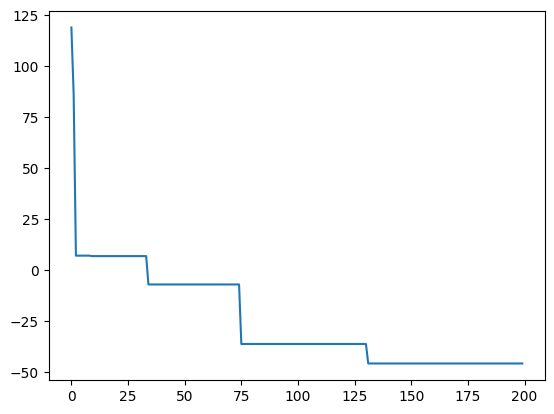

In [31]:
plt.plot(fits);

45.59039633988567

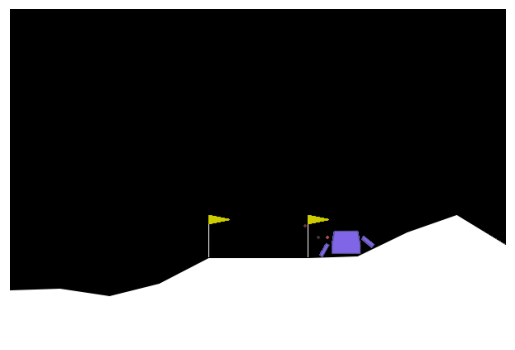

In [32]:
-fitness(x, ann, env, visul=True)

In [37]:
for i in range(50):
    solutions = np.array(es.ask())
    fits = [fitness(x, ann, env) for x in solutions]
    es.tell(solutions, fits)
    es.disp()
    
# plt.plot(fits);

   62   1736 -4.256729795045825e+01 1.0e+00 1.80e-01  2e-01  2e-01 1:05.6
   73   2044 -6.709472587864479e+01 1.0e+00 1.77e-01  2e-01  2e-01 1:17.5
   78   2184 -8.816375113049079e+01 1.0e+00 1.76e-01  2e-01  2e-01 1:29.7
   89   2492 -6.709472587864479e+01 1.0e+00 1.74e-01  2e-01  2e-01 1:42.9
  100   2800 -7.276735581056403e+01 1.0e+00 1.72e-01  2e-01  2e-01 1:52.3
  108   3024 -4.374854638458493e+01 1.0e+00 1.71e-01  2e-01  2e-01 2:07.9


70.78389873587051

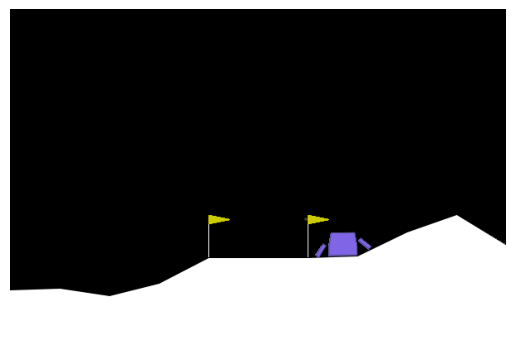

In [36]:
x = es.result[0]
-fitness(x, ann, env, visul=True)

It seems that the cma algorithm performs better for similar number of evaluations.

### Personal Notes
Take aways:
Diversity loss if all individuals in the generation perform the same (in fitness)
    diversity loss leads to progress stagnation
    progress stagnation doesn't mean diversity loss necessarily, maybe the problem is too difficult.
Convergence can also be checked by visualizing results(does the lander land well, fuel, breaking, location)

1+lambda is normal distribution
cma has a variable distribution (for the individuals in each generation)

Problem with CMA-ES is the cma part, the matrix computationally expensive.
O(n²) so bad performance past 1billion parameters